# Medical Images Project
---
This proposal 3 objectives:  
1. DICOM loading and visualization
2. 3D Image Segmentation
3. 3D Rigid Coregistration

As we can choose 2 of the 3 objectives, we choose 1 and 2.

## DICOM loading and visualization section

**a) Download the sample RadCTTACEomics DDDD (click here), where DDDD is the sample associated to you (see assignment in Aula Digital).**  

RadCTTACEomics_1447
  
- **Reference image**: 11_AP_Ax5.00mm
- **Input image**: 31_EQP_Ax5.00mm


In [1]:
#Constants
path_reference="../1447/11_AP_Ax5.00mm/"
path_input="../1447/31_EQP_Ax5.00mm/"
path_roi_liver="../1447/11_AP_Ax5.00mm_ManualROI_Liver.dcm"
path_roi_tumor="../1447/11_AP_Ax5.00mm_ManualROI_Tumor.dcm"

**b) Visualize it with the help of a third party DICOM visualizer (3D-Slicer is recommended).**   
To help use with the visualization we follow the advices from:
3rd party visualization: https://spujol.github.io/SlicerDICOMTutorial/3DSlicer_DICOMTutorial_SoniaPujol.pdf


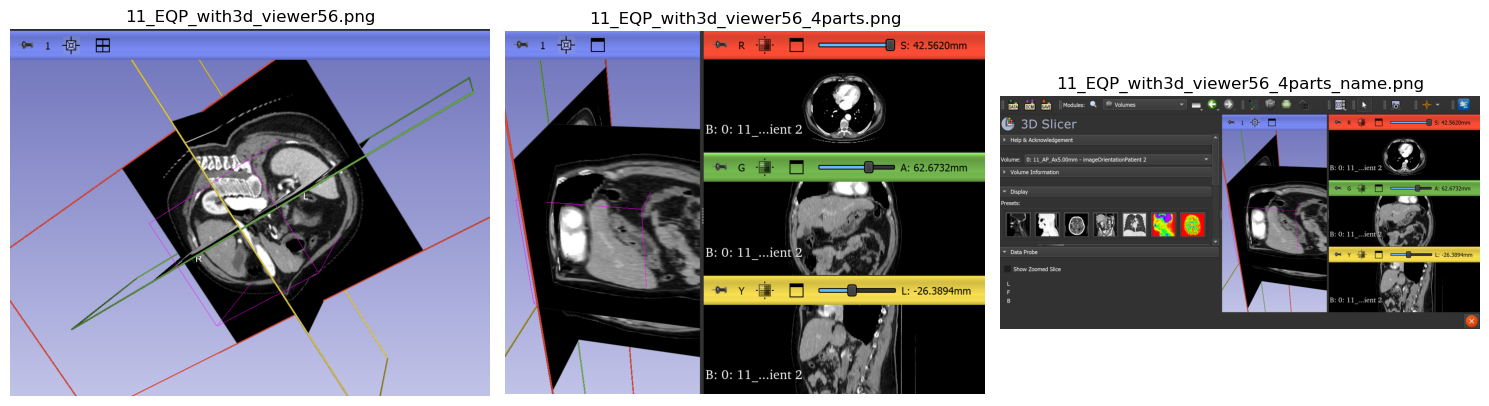

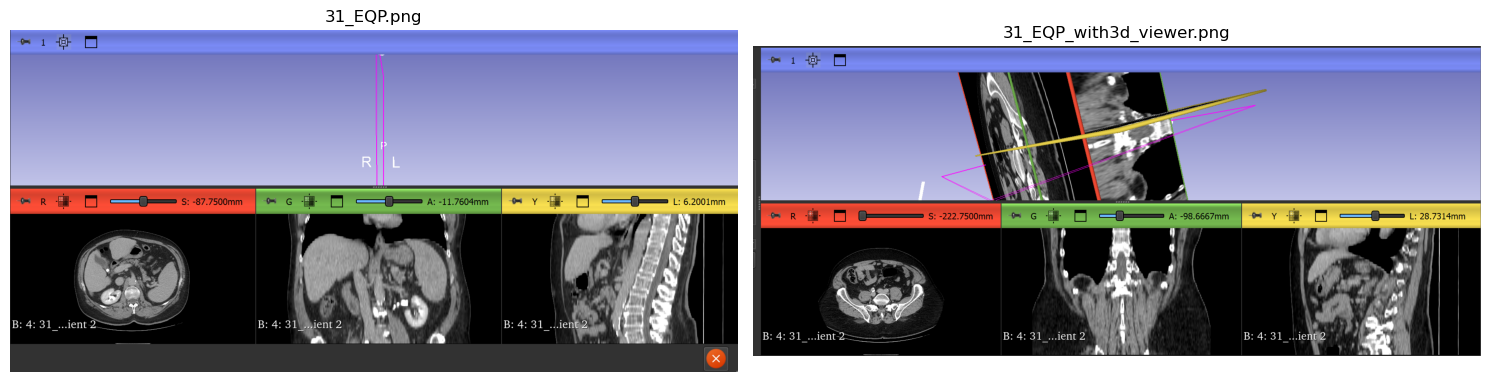

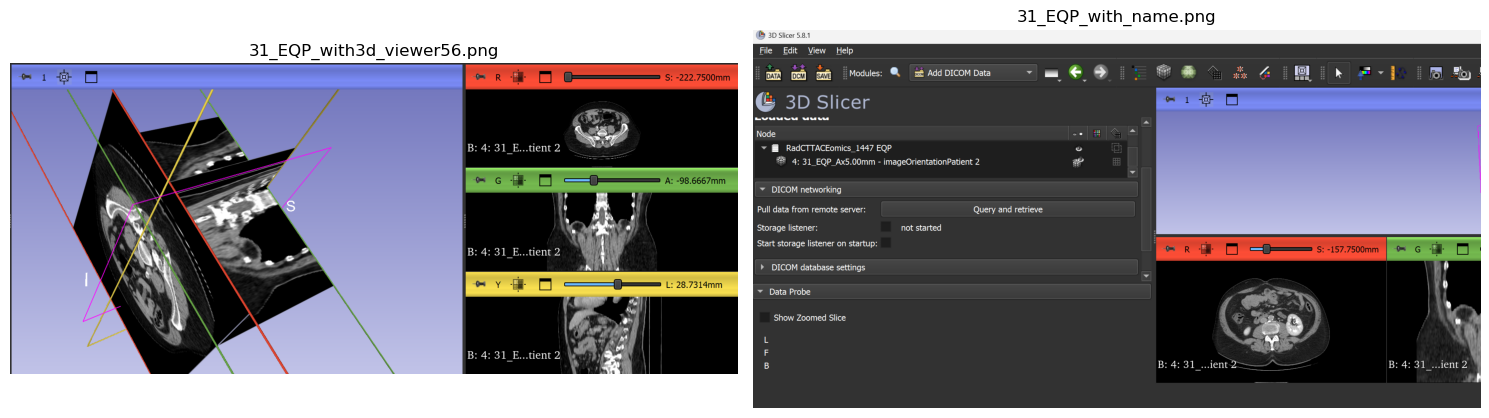

In [5]:
#Load screenshots from 3Dslicer
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


folder_path = "3d_slicer_photos/"
image_paths = list(Path(folder_path).glob('*.png'))  


group_pattern = [3, 2, 2]
groups = []
start_idx = 0

for count in group_pattern:
    end_idx = start_idx + count
    groups.append(image_paths[start_idx:end_idx])
    start_idx = end_idx

for group in groups:
    plt.figure(figsize=(15, 5))
    
    for idx, img_path in enumerate(group, 1):
        img = Image.open(img_path)
        
        plt.subplot(1, len(group), idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_path.name)
    
    plt.tight_layout()
    plt.show()


Is need to visualize this as in 3d slicer, using python

c) Load the reference CT image (pydicom) and the associated segmentations (highdicom).  
Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers. Some relevant headers include:  
- ‘Acquisition Number’.
- ‘Slice Index’.
- ‘Per-frame Functional Groups Sequence’ -> ‘Image Position Patient’.
- ‘Segment Identification Sequence’ -> ‘Referenced Segment Number’
---
DICOM segmentations are specialized objects in the DICOM standard used to represent segmented regions of interest (ROIs) within medical images. These segmentations are typically stored using the Segmentation Storage SOP Class (SOPClassUID = 1.2.840.10008.5.1.4.1.1.66.4) and are part of the enhanced multiframe DICOM format.

To order the attributes consistently while considering one axis from the 3D position, follow these steps:

- Acquisition Number: Start by sorting images based on the acquisition number. This ensures that images from different scans (e.g., pre-contrast vs. post-contrast) are grouped separately. A smaller acquisition number indicates an earlier scan, so it should come first.

- Slice Index: Within each acquisition group, sort the images by their slice index. This arranges the slices in the correct sequential order for reconstructing the 3D volume.

- Image Position Patient (Specific Axis): If there is a tie in the slice index, sort the images based on one specific axis from the 3D position (e.g., the z-axis for axial slices). Consistently using one axis ensures proper alignment of slices in 3D space along that dimension.

- Referenced Segment Number: Finally, if all previous attributes are identical, sort by the referenced segment number to distinguish between different anatomical regions or structures within the image.

This approach ensures consistency by focusing on a single axis for spatial alignment while maintaining a hierarchical ordering structure.

In [2]:
import os
import pydicom
import highdicom as hd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pydicom
import os
from typing import List
def load_dicom_files(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    datasets = [pydicom.dcmread(f) for f in files]
    return datasets

def extract_read_headers(dcm_files):
    headers = []
    for dcm_file in dcm_files:
        acquisition_number = dcm_file.get('AcquisitionNumber', None)
        slice_index = dcm_file.InstanceNumber
        img_position_patient = dcm_file.ImagePositionPatient if 'ImagePositionPatient' in dcm_file else None
        referenced_segment_number = dcm_file.get((0x0062, 0x000B), None)
        headers.append({
            'file': dcm_file,
            'acquisition_number': acquisition_number,
            'slice_index': slice_index,
            'image_position_patient': img_position_patient,
            'referenced_segment_number': referenced_segment_number
        })
    return headers

def rearrange_img_segmentation_by_headers(headers):
    # Sort headers based on the relevant attributes
    sorted_headers = sorted(headers, key=lambda x: (
        x['acquisition_number'] if x['acquisition_number'] is not None else 0,
        x['slice_index'] if x['slice_index'] is not None else 0,
        x['image_position_patient'][2] if x['image_position_patient'] is not None else 0,  # Sort by Z-axis
        x['referenced_segment_number'] if x['referenced_segment_number'] is not None else 0
    ))

    return sorted_headers
def extract_pixel_arrays(sorted_headers):
    pixel_arrays = []
    for header in sorted_headers:
        dcm_file = header['file']
        pixel_array = dcm_file.pixel_array
        pixel_arrays.append(pixel_array)
    return pixel_arrays

def visualize_sorted_slices(sorted_headers, num_slices=5):
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        axes[i].imshow(sorted_headers[i]['file'].pixel_array, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Slice {i+1}")
    plt.show()


def save_sorted_images(sorted_headers, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, header in enumerate(sorted_headers):
        output_path = os.path.join(output_folder, f"sorted_image_{i}.dcm")
        header['file'].save_as(output_path)

# Example usage
dcm_files = load_dicom_files(path_reference)
headers = extract_read_headers(dcm_files)
sorted_headers = rearrange_img_segmentation_by_headers(headers)
pixel_arrays = extract_pixel_arrays(sorted_headers)

# Display sorted headers and pixel arrays
for i, header in enumerate(sorted_headers):
    print(f"Header {i+1}:")
    print(f"  Acquisition Number: {header['acquisition_number']}")
    print(f"  Slice Index: {header['slice_index']}")
    print(f"  Image Position Patient: {header['image_position_patient']}")
    print(f"  Referenced Segment Number: {header['referenced_segment_number']}")
    print(f"  Pixel Array Shape: {pixel_arrays[i].shape}")


Header 1:
  Acquisition Number: 1
  Slice Index: 1
  Image Position Patient: [5.797, -187.399, 115.75]
  Referenced Segment Number: None
  Pixel Array Shape: (512, 512)
Header 2:
  Acquisition Number: 1
  Slice Index: 2
  Image Position Patient: [-200.202, -194.642, 42.562]
  Referenced Segment Number: None
  Pixel Array Shape: (512, 512)
Header 3:
  Acquisition Number: 1
  Slice Index: 3
  Image Position Patient: [-200.202, -194.642, 37.562]
  Referenced Segment Number: None
  Pixel Array Shape: (512, 512)
Header 4:
  Acquisition Number: 1
  Slice Index: 4
  Image Position Patient: [-200.202, -194.642, 32.562]
  Referenced Segment Number: None
  Pixel Array Shape: (512, 512)
Header 5:
  Acquisition Number: 1
  Slice Index: 5
  Image Position Patient: [-200.202, -194.642, 27.562]
  Referenced Segment Number: None
  Pixel Array Shape: (512, 512)
Header 6:
  Acquisition Number: 1
  Slice Index: 6
  Image Position Patient: [-200.202, -194.642, 22.562]
  Referenced Segment Number: None
  P

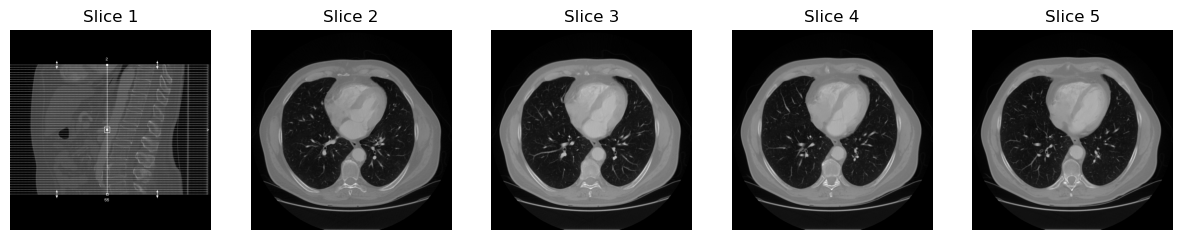

In [30]:
visualize_sorted_slices(sorted_headers)

Referenced Segment Number, is from the segmentation data, then we have to use path_roi_tumor and path_roi_liver.  


In [45]:
pip install --upgrade highdicom

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install --upgrade "highdicom>=0.25.1"

ERROR: Could not find a version that satisfies the requirement highdicom>=0.25.1 (from versions: 0.1.0, 0.2.0, 0.3.0, 0.4.0, 0.4.1, 0.5.0, 0.5.1, 0.6.0, 0.7.0, 0.8.0, 0.9.0, 0.9.1, 0.9.2, 0.10.0, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.14.2, 0.15.0, 0.15.1, 0.15.2, 0.15.3, 0.16.0, 0.17.0, 0.18.0, 0.18.1, 0.18.2, 0.18.3, 0.18.4, 0.19.0, 0.20.0, 0.21.0, 0.21.1, 0.22.0)
ERROR: No matching distribution found for highdicom>=0.25.1


In [4]:
print(hd.__version__)

0.22.0


In [3]:
import highdicom as hd
import pydicom
def load_seg_dcm(file_path):
    dcm=pydicom.dcmread(file_path)
    return hd.seg.Segmentation(dcm)
def headers_seg_dcm(dcm_file):

    # Get metadata
    metadata = {
        "AcquisitionNumber": seg.get("AcquisitionNumber", None),
        "Slices": [
            {
                "Index": i+1,
                "Position": frame.PlanePositionSequence[0].ImagePositionPatient
            }
            for i, frame in enumerate(seg.PerFrameFunctionalGroupsSequence)
        ],
        "Segments": [
        {
            "Number": segment.SegmentNumber,
            "ReferencedNumber": segment.SegmentIdentificationSequence[0].ReferencedSegmentNumber
        }
        for segment in seg.SegmentSequence
    ]
    }
    return metadata

dcm=load_seg_dcm(path_roi_liver)
headers=headers_seg_dcm(dcm)
print(headers)

TypeError: __init__() missing 11 required positional arguments: 'pixel_array', 'segmentation_type', 'segment_descriptions', 'series_instance_uid', 'series_number', 'sop_instance_uid', 'instance_number', 'manufacturer', 'manufacturer_model_name', 'software_versions', and 'device_serial_number'

    '''
    slice_indices = []
    for i, frame_group in enumerate(seg.PerFrameFunctionalGroupsSequence):
        slice_position = frame_group.PlanePositionSequence[0].ImagePositionPatient
        slice_indices.append({
        "Frame": i + 1,
        "SlicePosition": slice_position
        })
    image_positions = []
    for frame_group in seg.PerFrameFunctionalGroupsSequence:
        position_sequence = frame_group.PlanePositionSequence[0]
        image_positions.append(position_sequence.ImagePositionPatient)
    segment_numbers = []
    for segment in seg.SegmentSequence:
        segment_numbers.append(segment.SegmentNumber)
        # For direct access to identification metadata:
        ref_segment_number = segment.SegmentIdentificationSequence[0].ReferencedSegmentNumber
    '''

**d) Create an animation (e.g. gif file) with a rotating Maximum Intensity Projection on the
coronal-sagittal planes, visualizing the tumoral mask.**

In order to perform image enhancement, window center and windown width must be obtained.


In [4]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

def get_windowing(dcm):
    """
    Retrieves window center and width from a DICOM file.
    If not present, estimates them from the pixel data.
    """
    try:
        window_center = dcm.WindowCenter
        window_width = dcm.WindowWidth
        print(f"window_center: {window_center}", f"window_width: {window_width}")
        return window_center, window_width
    except AttributeError:
        # Estimate windowing if not present
        pixels = dcm.pixel_array
        max_value = np.max(pixels)
        min_value = np.min(pixels)
        window_center = (max_value + min_value) / 2
        window_width = max_value - min_value
        return window_center, window_width

def apply_windowing(pixel_array, window_center, window_width):
    """
    Applies windowing to the pixel data.
    """
    lower_bound = window_center - window_width / 2
    upper_bound = window_center + window_width / 2
    windowed_array = np.clip(pixel_array, lower_bound, upper_bound)
    return windowed_array

In [5]:
window_center, window_width = 40, 400
windowed_ct_images = np.array([apply_windowing(img, window_center, window_width) for img  in pixel_arrays])

In [11]:
print(pixel_arrays[0].shape)

(512, 512)


In [6]:
liver_segmentation = pydicom.dcmread(path_roi_liver)
liver_image = liver_segmentation.pixel_array

In [7]:
tumor_segmentation = pydicom.dcmread(path_roi_tumor)
tumor_image = tumor_segmentation.pixel_array

In [9]:
print(tumor_image.shape)

(13, 512, 512)


Check planes on the reference image

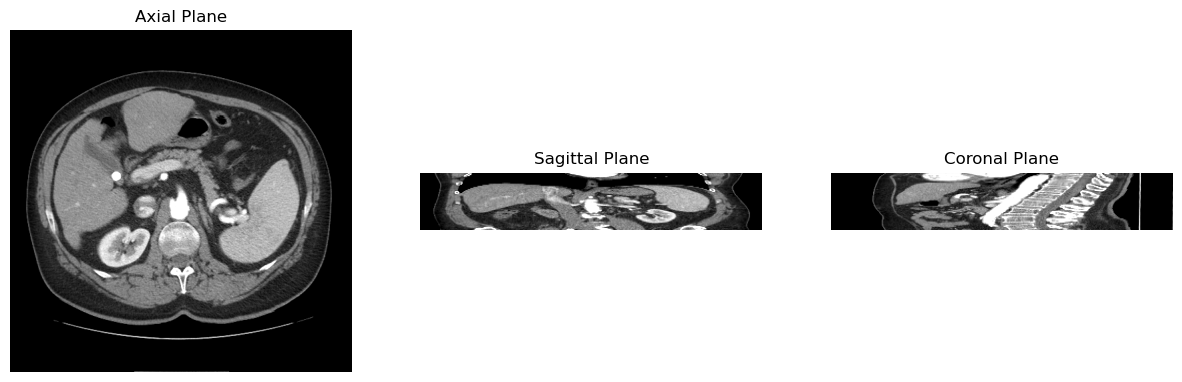

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def obtain_aspects_planes(images):
    sample_img=images[0]
    pixel_spacing = sample_img.PixelSpacing  #is an array for the x and y 
    slice_thickness = sample_img.SliceThickness
    #aspects ratios
    aspect_ratio_sagittal = slice_thickness / pixel_spacing[1]
    aspect_ratio_coronal = slice_thickness / pixel_spacing[0]
    return aspect_ratio_sagittal, aspect_ratio_coronal

def visualize_planes(ct_volume, aspect_ratio_sagittal, aspect_ratio_coronal):
   
    # Obtaining planes
    axial_plane = ct_volume[ct_volume.shape[0] // 2, :, :]
    coronal_plane = ct_volume[:, :, ct_volume.shape[2] // 2]
    sagittal_plane = ct_volume[:, ct_volume.shape[1] // 2, :]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Visualize planes with aspect
    axes[0].imshow(axial_plane, cmap='gray')
    axes[0].set_title('Axial Plane')
    axes[0].axis('off')
    
    axes[1].imshow(sagittal_plane, cmap='gray', aspect=aspect_ratio_sagittal)
    axes[1].set_title('Sagittal Plane')
    axes[1].axis('off')
    
    axes[2].imshow(coronal_plane, cmap='gray', aspect=aspect_ratio_coronal)
    axes[2].set_title('Coronal Plane')
    axes[2].axis('off')

    plt.show()
    
aspect_ratio_sagittal, aspect_ratio_coronal=obtain_aspects_planes(dcm_files)
visualize_planes(windowed_ct_images, aspect_ratio_sagittal, aspect_ratio_coronal)



In [ ]:
import matplotlib.animation as animation
import pydicom
import scipy.ndimage
import imageio
import os
from matplotlib.animation import FuncAnimation
from scipy.ndimage import rotate

class Axis(Enum):
    CORONAL = 1
    SAGGITAL = 2

def obtain_mip(volume, axis):
    return np.max(volume, axis=axis)
def create_mask(segmentation):
    return segmentation > 0
def overlay_mask(image, mask, alpha=0.5):
    masked = np.ma.masked_where(mask == 0, mask)
    return image + alpha * masked
def create_rotation_gif(ref_img,seg_tumor):
    '''
    imagens+mascara de tumor,
    rotar, establecer angulo, y frames (rotar 360 en total)
    guardar gif.
    '''
    

In [46]:
save_sorted_images(rearranged_pixel_arrays, '../test/') #using dicom format

This dataset appears to represent a CT Image Storage object, as indicated by the SOP Class UID (CT Image Storage) and other attributes related to CT imaging. To extract the Referenced Segment Number, you would need a DICOM Segmentation object that contains labeled segments and their corresponding metadata.

### dudas

hacerlo con el segmentado de roi, y con el de input ordernar.
MIP